In [41]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные для тестовой и контрольной группы.

In [7]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [8]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Построим график распределения CTR в наших группах.

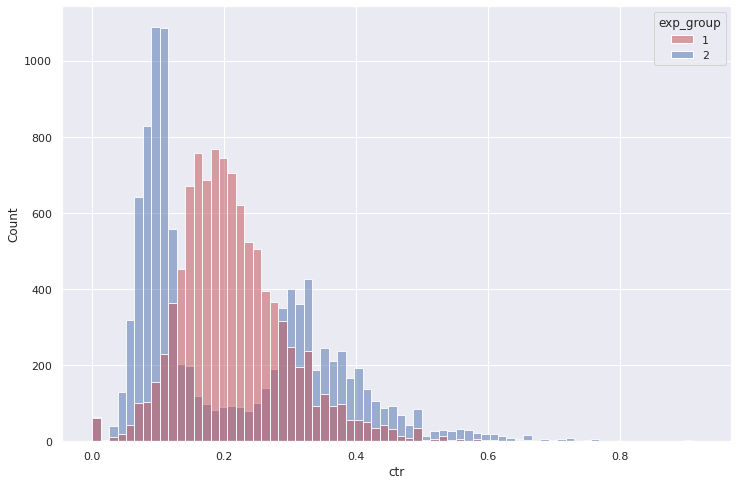

In [18]:
sns.set(rc={'figure.figsize':(12,8)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue = 'exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

По графику заметно, что распределение показателей CTR в контрольной группе нормальное. В то время как в тестовой бимодальное. У какой-то части пользователей CTR все же увеличился, но у большей части показатель снизился, о чем свидетельствуют различия в частоте встречаемости двух наших мод в тестовой группе. Также появились некоторые выбросы в сторону больших показателей CTR. 

Проведем сравнение наших групп t-тестом.

In [27]:
stats.ttest_ind(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

t-тест показывет, что значимых различий в группах нету (pvalue > 0.05)

Проведем сравнение наших групп Пуассоновским бутстрепом.

In [16]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

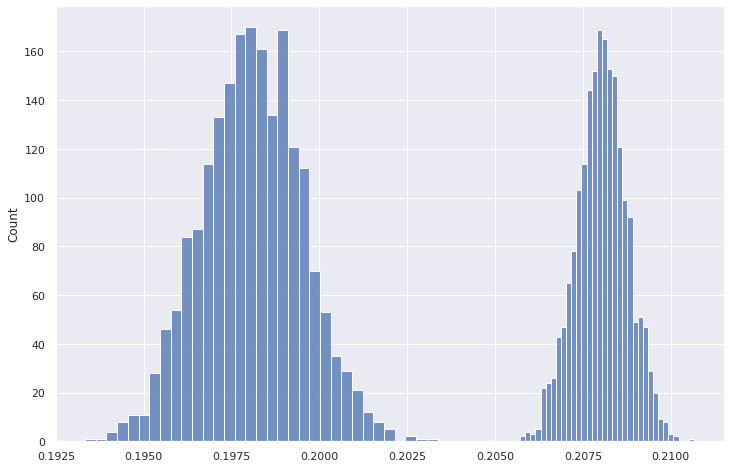

In [19]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

Распределения показывают, что показатели глобальных CTR даже не пересекаются. 
Посмотрим также на распределение разниц CTR. 

<AxesSubplot:ylabel='Count'>

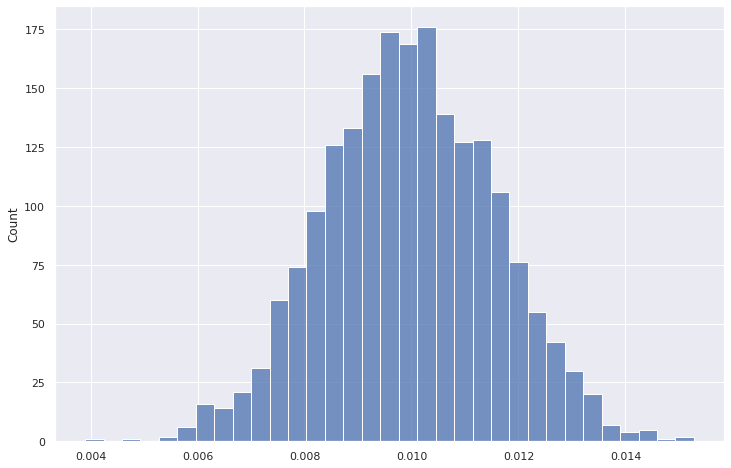

In [26]:
sns.histplot(ctr1 - ctr2)

Проведем сравнение наших групп тестом Манна-Уитни.

In [28]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,  df[df.exp_group == 2].ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

В отличии от t-теста, тест Манна-Уитни показал, что в наших группах заметны значимые различия (pvalue < 0.05).

Далее сравненим наши группы на сглаженных значениях CTR.

In [30]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [37]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [38]:
group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

Визаульно сравним распределения показателей CTR (до и после сглаживания).

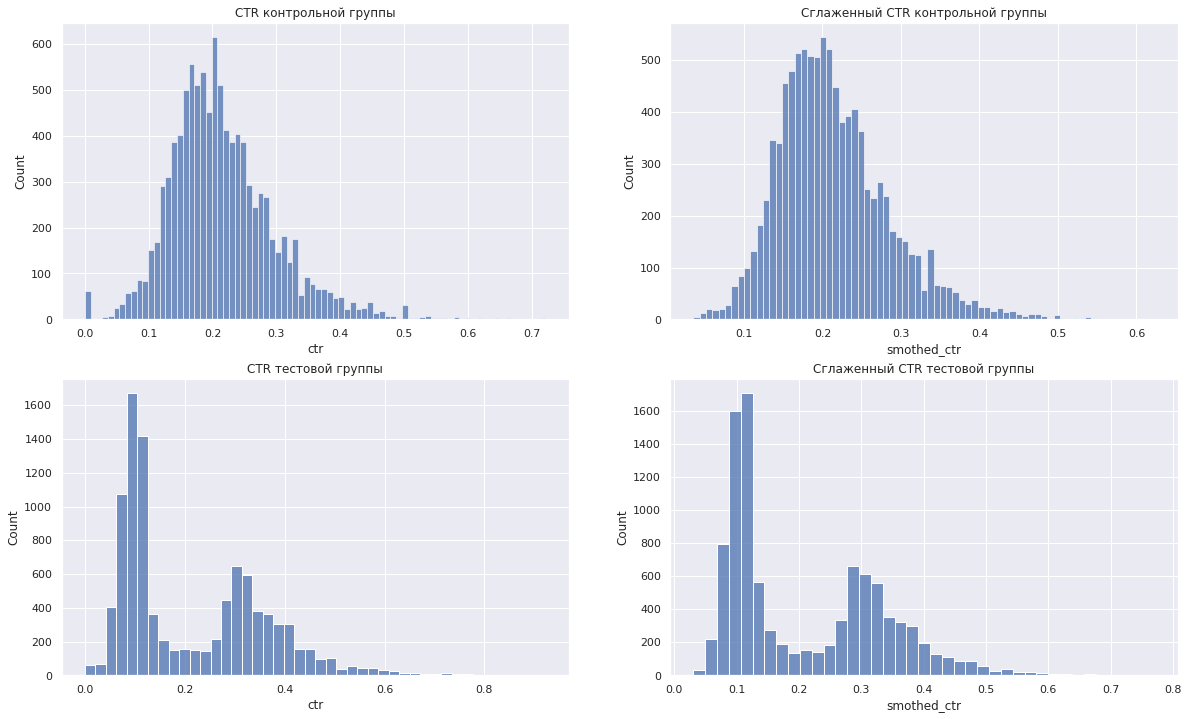

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(20,12))
sns.histplot(group1.ctr, ax=ax[0,0], kde=False)
ax[0,0].set_title('CTR контрольной группы')
sns.histplot(group1.smothed_ctr, ax=ax[0,1], kde=False)
ax[0,1].set_title('Сглаженный CTR контрольной группы')
sns.histplot(group2.ctr, ax=ax[1,0], kde=False)
ax[1,0].set_title('CTR тестовой группы')
sns.histplot(group2.smothed_ctr, ax=ax[1,1], kde=False)
ax[1,1].set_title('Сглаженный CTR тестовой группы')
plt.show()



Запустим t-тест на сглаженных CTR.

In [56]:
stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

Данный тест показывает, что занчимые различия в группах существуют (pvalue < 0.05).

Проведем бакетное преобразование.

In [61]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-01-31' and '2023-02-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket_df = ph.read_clickhouse(q, connection=connection)

Запустим t-тест поверх бакетного преобразования.

In [69]:
stats.ttest_ind(bucket_df[bucket_df.exp_group == 1].bucket_ctr, bucket_df[bucket_df.exp_group == 2].bucket_ctr, equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Запустим тест Манна-Уитни поверх бакетного преобразования.

In [68]:
stats.mannwhitneyu(bucket_df[bucket_df.exp_group == 1].bucket_ctr, bucket_df[bucket_df.exp_group == 2].bucket_ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Оба теста поверх бакетного преобразования показали значимые различия в наших группах (pvalue < 0.05).

In [70]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-24' and '2023-01-30'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df_12 = ph.read_clickhouse(q, connection=connection)

In [72]:
stats.ttest_ind(df_12[df_12.exp_group == 1].ctr, 
                   df_12[df_12.exp_group == 2].ctr, 
                   equal_var = False)

Ttest_indResult(statistic=-2.017208642179449, pvalue=0.04368941747573785)

ВЫВОД

По графикам распределения показателей CTR для наших групп визуально заметно, что распредление для тестовой группы не является нормальным. Из-за этого проведенный нами t-тест не показал значимых различий в нашем эксперементе.
Проведенный t-тест уже на сглаживанных показателях CTR показал все таки значимые различия, хотя по построенным графикам нормальность распределения также не наблюдается. И также t-тест поверх бакетного преобразования показал различия. 
Все тесты Манна-Уитни показали значимые различия в группах.
При этом Пуассоновский бутстреп показал, что графики распределения глобальных CTR не пересекаются.
Как и говорилось изначально, наш алгоритм для части пользователей увеличивает показатель CTR, но для большинства все же снижает. Возможно это разделение связанно с каким-то признаком наших пользователей (например пол, возраст).
На основании этого можно сделать общий вывод, что раскатывать новый алгоритм пока не стоит. Необходимо более детально изучить, как и на какие группы влияет наше нововведение.